ЗАДАНИЕ 1: создать сверточную нейронную сеть, решающую задачу классификации животных на классы СОБАКА, КОШКА или ДИКОЕ по их изображению. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from CNN_ import ConvNet
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#изменение размера изображения и преобразование в тензор
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

#загружаем набор данных изображений
train_dataset = datasets.ImageFolder(root='animals/train', transform=data_transform)
#создает загрузчик данных для обучения
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = datasets.ImageFolder(root='animals/val', transform=data_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

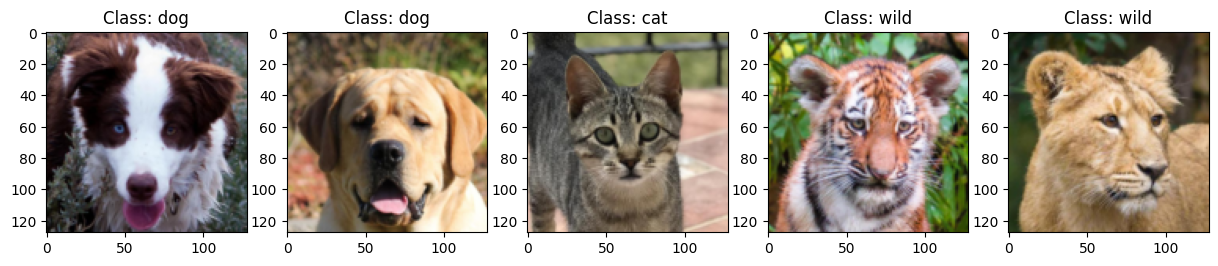

In [3]:
# Функция для отображения случайной выборки
def show_random_samples(dataset, num_samples=5):
    #получает список имен классов из объектов датасета
    class_names = dataset.classes
    # Получаем случайные индексы из тренировочного датасета
    random_indices = random.sample(range(len(dataset)), num_samples)

    # Создаем загрузчик данных для случайной выборки, используя полученные случайные индексы
    random_loader = DataLoader(dataset, batch_size=num_samples, sampler=SubsetRandomSampler(random_indices))

    # Получаем один батч (набор) изображений и соответствующих им меток класса из случайной выборки
    images, labels = next(iter(random_loader))

    # Преобразование тензоров изображения в массивы numpy
    images = images.numpy()

    # Вывод изображений
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    #Цикл по изображениям в батче
    for i in range(num_samples):
        #отображает текущее изображение, транспонируя размерности 
        axes[i].imshow(np.transpose(images[i], (1, 2, 0)))
        #Устанавливает заголовок с именем класса для текущего изображения
        axes[i].set_title(f'Class: {class_names[labels[i].item()]}')

    plt.show()

# Используйте функцию, передавая ваш тренировочный датасет (5 случайных изображений)
show_random_samples(train_dataset, num_samples=5)

In [4]:
#Подготовка модели к обучению
#выбор устройства cpu или gpy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#создает экземпляр модели ConvNet с указанным числом классов и отправляете ее на выбранное устройство (cpu или gpy) 
model = ConvNet(num_classes=3).to(device)
#Функция потерь. кросс-энтропическая
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
from ipywidgets import IntProgress
from IPython.display import display

In [6]:
num_epochs = 3 # Количество эпох
progress = IntProgress(min=0, max=len(train_loader))
display(progress)

for epoch in range(num_epochs):
    progress.value = 0
    progress.description = "Epoch " + str(epoch + 1) + "/" + str(num_epochs)
    model.train()
    #цикл по батчам тренировачного датасета
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        #обнуляет градиенты перед обратным распространением
        optimizer.zero_grad()
        #Получает прогнозы модели для входных данных
        outputs = model(images)
        #вычисляет значения функции потерь
        loss = criterion(outputs, labels)
        #выполняет обратное распространение для вычисления грдиентов
        loss.backward()
        #обновляет параметры модели с использованием оптимизатора
        optimizer.step()
        progress.value += 1

    #переключается в режим оценки для валидации
    model.eval()
    correct = 0
    total = 0
    #отключает вычисление градиентов во время валидации
    with torch.no_grad():
        #цикл по батчам валидационного датасета
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            #получает предсказанные классы для выходов модели
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy}')

# Сохранение модели
torch.save(model.state_dict(), 'conv_net.pth')

IntProgress(value=0, max=458)

Epoch 1/3, Loss: 0.7930927276611328, Accuracy: 0.742
Epoch 2/3, Loss: 0.12187974900007248, Accuracy: 0.8733333333333333
Epoch 3/3, Loss: 0.8612307906150818, Accuracy: 0.888


In [7]:
#Загрузка предварительно обученных параметров модели из файла conv_net.pth 
model = ConvNet().to(device)
model.load_state_dict(torch.load("conv_net.pth"))
#переводит режим оценки, это полезно при использовании модели для предсказаний
model.eval()

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=131072, out_features=3, bias=True)
)

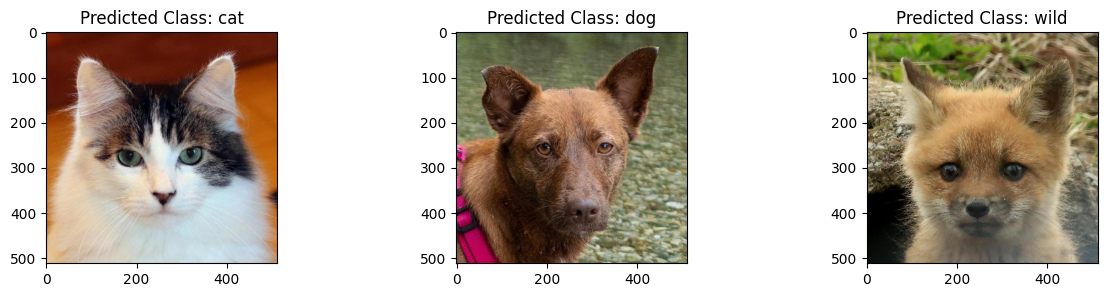

In [8]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Путь к вашему изображению
images = ['animals/val/cat/flickr_cat_000008.jpg',
          'animals/val/dog/flickr_dog_000043.jpg',
          'animals/val/wild/flickr_wild_000012.jpg']


#создает область отображения изображений и предсказаний
fig, axes = plt.subplots(1, len(images), figsize=(15, 3))

#цикл по путям изображений
for image_path, i in zip(images, range(len(images))):
    # Загрузка изображения
    image = Image.open(image_path)

    # Применение трансформаций к изображению
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])

    # Преобразование изображения и добавление размерности пакета
    input_image = transform(image).unsqueeze(0)

    # Передача изображения через модель
    model.eval()  # Установка модели в режим оценки (выключение режима обучения)
    #отключает вычисление градиентов во время предсказания
    with torch.no_grad():
        input_image = input_image.to(device)
        #получет предсказание модели для входного изображения
        output = model(input_image)

    # Получение предсказаного класса
    _, predicted_class = torch.max(output, 1)
    predicted_class = predicted_class.item()

    # Вывод результата
    class_names = train_dataset.classes  # Замените на свои классы
    #получаем имя предсказанного класса из списка классов
    predicted_class_name = class_names[predicted_class]

    # Вывод изображения и предсказания
    axes[i].imshow(np.asarray(image))
    axes[i].set_title(f'Predicted Class: {predicted_class_name}')
plt.show()
